In [ ]:
#code adapted from https://keras.io/examples/vision/grad_cam/

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [4]:
# %%
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', type=str, default='InceptionV3')
parser.add_argument('--weights', type=str, default='radimagenet')
parser.add_argument('--n_layers', type=int, default=4)
parser.add_argument('--n_neurons', type=int, default=256)
parser.add_argument('--n_dropout', type=float, default=0.0)
parser.add_argument('--lr_1', type=float, default=3e-4)
parser.add_argument('--lr_2', type=float, default=3e-6)
parser.add_argument('--image_size', type=int, default=512, required=False)
parser.add_argument('--batch_size', type=int, default=16, required=False)

args = parser.parse_args("")

model_name = args.model_name
weights = args.weights
n_layers = args.n_layers
n_neurons = args.n_neurons
n_dropout = args.n_dropout
lr_1 = args.lr_1
lr_2 = args.lr_2
img_size = args.image_size
batch_size = args.batch_size


# %%
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.metrics import roc_curve, roc_auc_score, recall_score
from tensorflow.keras.applications import InceptionResNetV2, ResNet50, InceptionV3, DenseNet121, Xception
import tensorflow_hub as hub
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score


# %%
train_dir = '../data/split_1/train'
val_dir = '../data/split_1/val'
test_dir = '../data/split_1/test'


# %%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode='binary', seed=0, image_size=(img_size, img_size), batch_size=batch_size, color_mode='rgb')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir, label_mode='binary', seed=0, image_size=(img_size, img_size), batch_size=batch_size, color_mode='rgb')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='binary', seed=0, image_size=(img_size, img_size), batch_size=1, color_mode='rgb')


# %%
#Apply data augmentation
preprocessing_model = tf.keras.Sequential()
preprocessing_model.add(
    tf.keras.layers.experimental.preprocessing.RandomRotation(40))
preprocessing_model.add(
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2))
preprocessing_model.add(
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2))
preprocessing_model.add(
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"))
preprocessing_model.add(
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="vertical"))


# %%
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))


# %% [markdown]
# #only apply normalization to validation set
# val_ds = val_ds.unbatch().batch(batch_size)
# val_ds = val_ds.map(lambda images, labels:
#                     (normalization_layer(images), labels))

# %%

if model_name == 'InceptionResNetV2':
    preprocess_fx = tf.keras.applications.inception_resnet_v2.preprocess_input
    model_dir = "../RadImageNet/models/RadImageNet-IRV2_notop.h5"
    if weights == 'imagenet':
        base_model = InceptionResNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
    elif weights == 'radimagenet':
        base_model = InceptionResNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights=model_dir)
elif model_name == 'ResNet50':
    preprocess_fx = tf.keras.applications.resnet50.preprocess_input
    model_dir = "../RadImageNet/models/RadImageNet-ResNet50_notop.h5"
    if weights == 'imagenet':
        base_model = ResNet50(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
    elif weights == 'radimagenet':
        base_model = ResNet50(input_shape=(img_size, img_size, 3), include_top=False, weights=model_dir)
elif model_name == 'InceptionV3':
    preprocess_fx = tf.keras.applications.inception_v3.preprocess_input
    model_dir = "../RadImageNet/models/RadImageNet-InceptionV3_notop.h5"
    if weights == 'imagenet':
        base_model = InceptionV3(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
    elif weights == 'radimagenet':
        base_model = InceptionV3(input_shape=(img_size, img_size, 3), include_top=False, weights=model_dir)
elif model_name == 'DenseNet121':
    preprocess_fx = tf.keras.applications.densenet.preprocess_input
    model_dir = "../RadImageNet/models/RadImageNet-DenseNet121_notop.h5"
    if weights == 'imagenet':
        base_model = DenseNet121(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
    elif weights == 'radimagenet':
        base_model = DenseNet121(input_shape=(img_size, img_size, 3), include_top=False, weights=model_dir)
elif model_name == 'Xception':
    preprocess_fx = tf.keras.applications.xception.preprocess_input
    if weights == 'imagenet':
        base_model = tf.keras.applications.Xception(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
elif model_name == 'BiT':
    base_model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable=False)
    preprocess_fx = tf.keras.applications.resnet50.preprocess_input
    



inputs = keras.Input(shape=(img_size, img_size, 3))
y = preprocess_fx(inputs)
y = base_model(inputs, training=False)
y = keras.layers.GlobalAveragePooling2D()(y)
# for i in range(n_layers):
#     y = keras.layers.Dense(n_neurons, activation='relu')(y)
#     y = keras.layers.Dropout(n_dropout)(y)
outputs = keras.layers.Dense(1, activation='sigmoid')(y)
model = keras.Model(inputs, outputs)

# %%
early_stopping = keras.callbacks.EarlyStopping(patience=100, min_delta=1e-15, restore_best_weights=True)

# %%

model.compile(
    optimizer=keras.optimizers.Adam(lr_1), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
)

epochs = 1000

model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=early_stopping, verbose=1)
print('phase 1 complete')
# %%
#unfreeze all layers and train at lower learning rate
base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(lr_2), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
)
model.fit(train_ds, epochs=1000, validation_data=val_ds, callbacks=early_stopping, verbose=1)
print('phase 2 complete')

model.save('models/{}_{}_grad.h5'.format(model_name, weights))


Found 492 files belonging to 2 classes.
Found 165 files belonging to 2 classes.
Found 164 files belonging to 2 classes.
Epoch 1/1000


2023-02-13 18:55:13.840871: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8700
2023-02-13 18:55:14.874325: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-13 18:55:14.877640: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-02-13 18:55:14.877668: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-02-13 18:55:14.877778: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

31/31 [==============================] - 81s 2s/step - loss: 13.2685 - binary_accuracy: 0.5061 - auc: 0.5216 - val_loss: 0.7281 - val_binary_accuracy: 0.4788 - val_auc: 0.4891
Epoch 2/1000
31/31 [==============================] - 61s 2s/step - loss: 0.7021 - binary_accuracy: 0.4939 - auc: 0.5199 - val_loss: 0.7013 - val_binary_accuracy: 0.4970 - val_auc: 0.4936
Epoch 3/1000
31/31 [==============================] - 62s 2s/step - loss: 0.6912 - binary_accuracy: 0.5041 - auc: 0.5420 - val_loss: 0.6942 - val_binary_accuracy: 0.5333 - val_auc: 0.5689
Epoch 4/1000
31/31 [==============================] - 64s 2s/step - loss: 0.6934 - binary_accuracy: 0.5163 - auc: 0.5347 - val_loss: 0.6895 - val_binary_accuracy: 0.5273 - val_auc: 0.5575
Epoch 5/1000
31/31 [==============================] - 62s 2s/step - loss: 0.6856 - binary_accuracy: 0.5488 - auc: 0.5806 - val_loss: 0.6872 - val_binary_accuracy: 0.5273 - val_auc: 0.5752
Epoch 6/1000
31/31 [==============================] - 62s 2s/step - loss

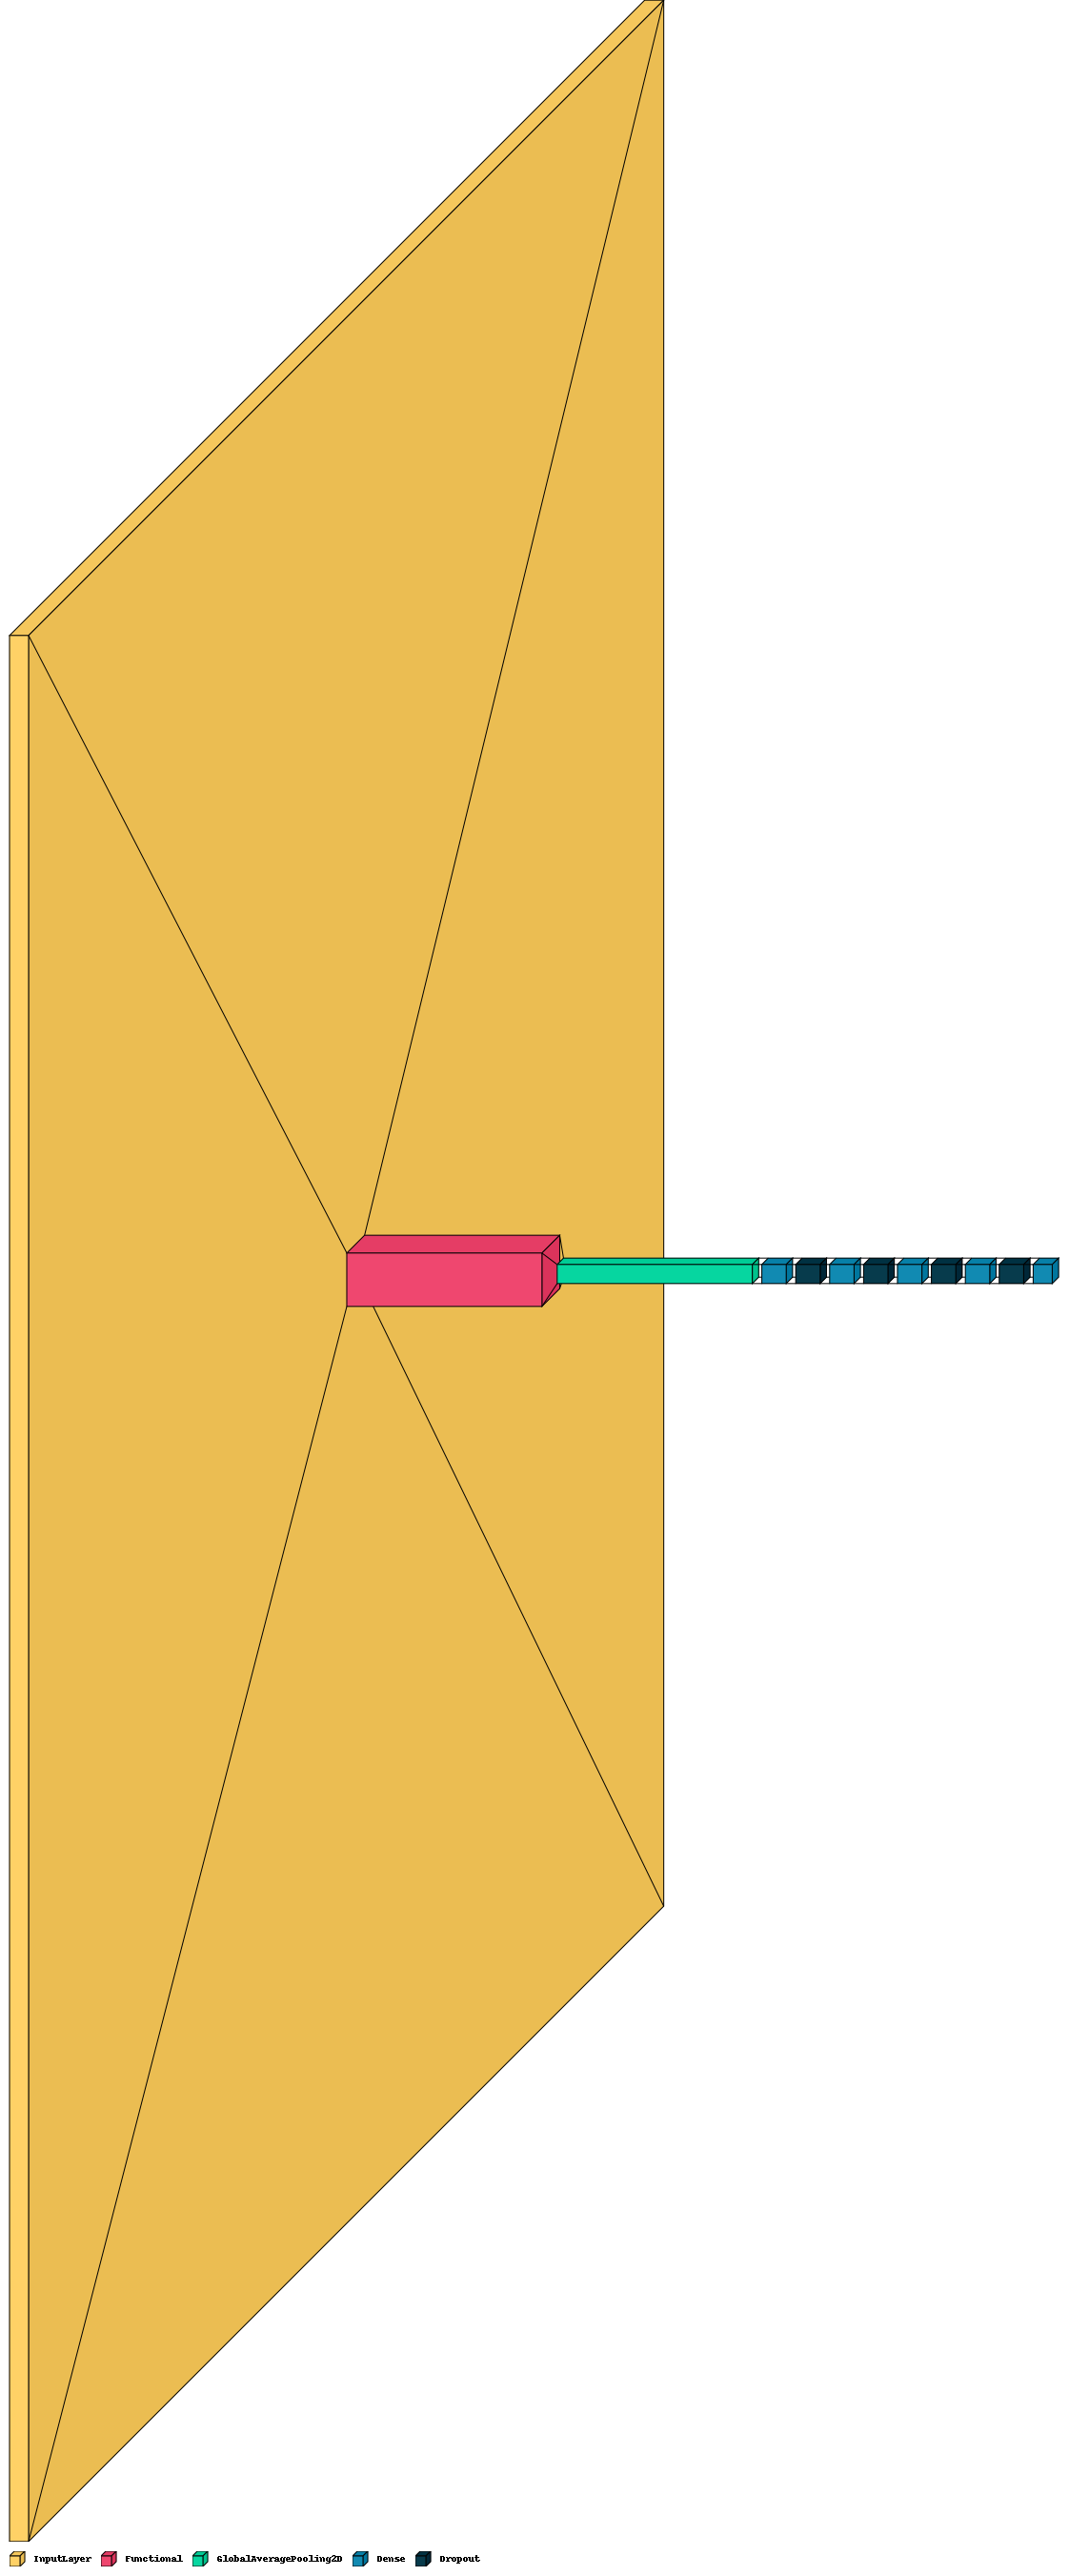

In [6]:
#visualize the model using visualkeras, with legend labels
import visualkeras as vk
from PIL import ImageFont
# font = ImageFont.truetype("arial.ttf", 12)
vk.layered_view(model, legend=True)

In [2]:
# Make model
model = tf.keras.models.load_model('models/InceptionV3_radimagenet_grad.h5')
model.summary()

2023-02-14 10:29:02.304814: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 10:29:03.819083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18278 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:81:00.0, compute capability: 8.6
2023-02-14 10:29:03.819804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9455 MB memory:  -> device: 1, name: NVIDIA TITAN V, pci bus id: 0000:02:00.0, compute capability: 7.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                             

In [3]:
#now we will use GradCAM to visualize the model's attention on the images
def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
find_target_layer(model)

'inception_v3'

In [4]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
last_conv_layer_name = find_target_layer(model)

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

img_size = (512, 512)
# The local path to our target image
img_path = r'/home/kchen/Documents/iom/data/jpg/1/9.jpg'
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

In [6]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [7]:
#get the names of the last 10 layers in the model
model.layers[-10:]

In [10]:
#get the names of the last 10 layers in the model
model.layers[:-10]

In [11]:
#remove the top of the model
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
grad_model

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'") at layer "conv2d_94". The following previous layers were accessed without issue: []

In [24]:
# Print what the top predicted class is
preds = model.predict(img_array)
preds


array([[0.6971517]], dtype=float32)

In [25]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'") at layer "conv2d_94". The following previous layers were accessed without issue: []

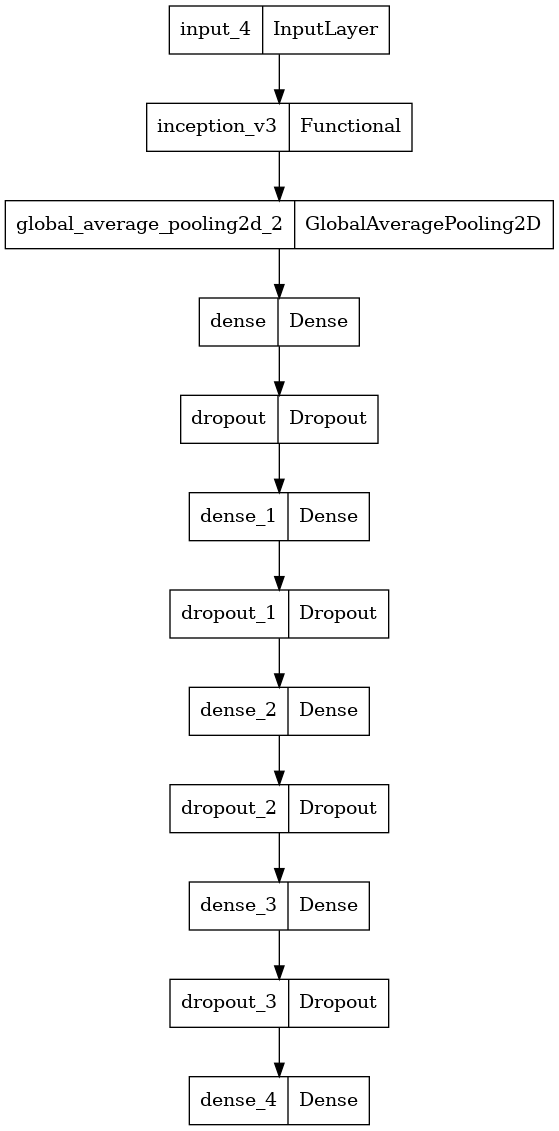

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model)

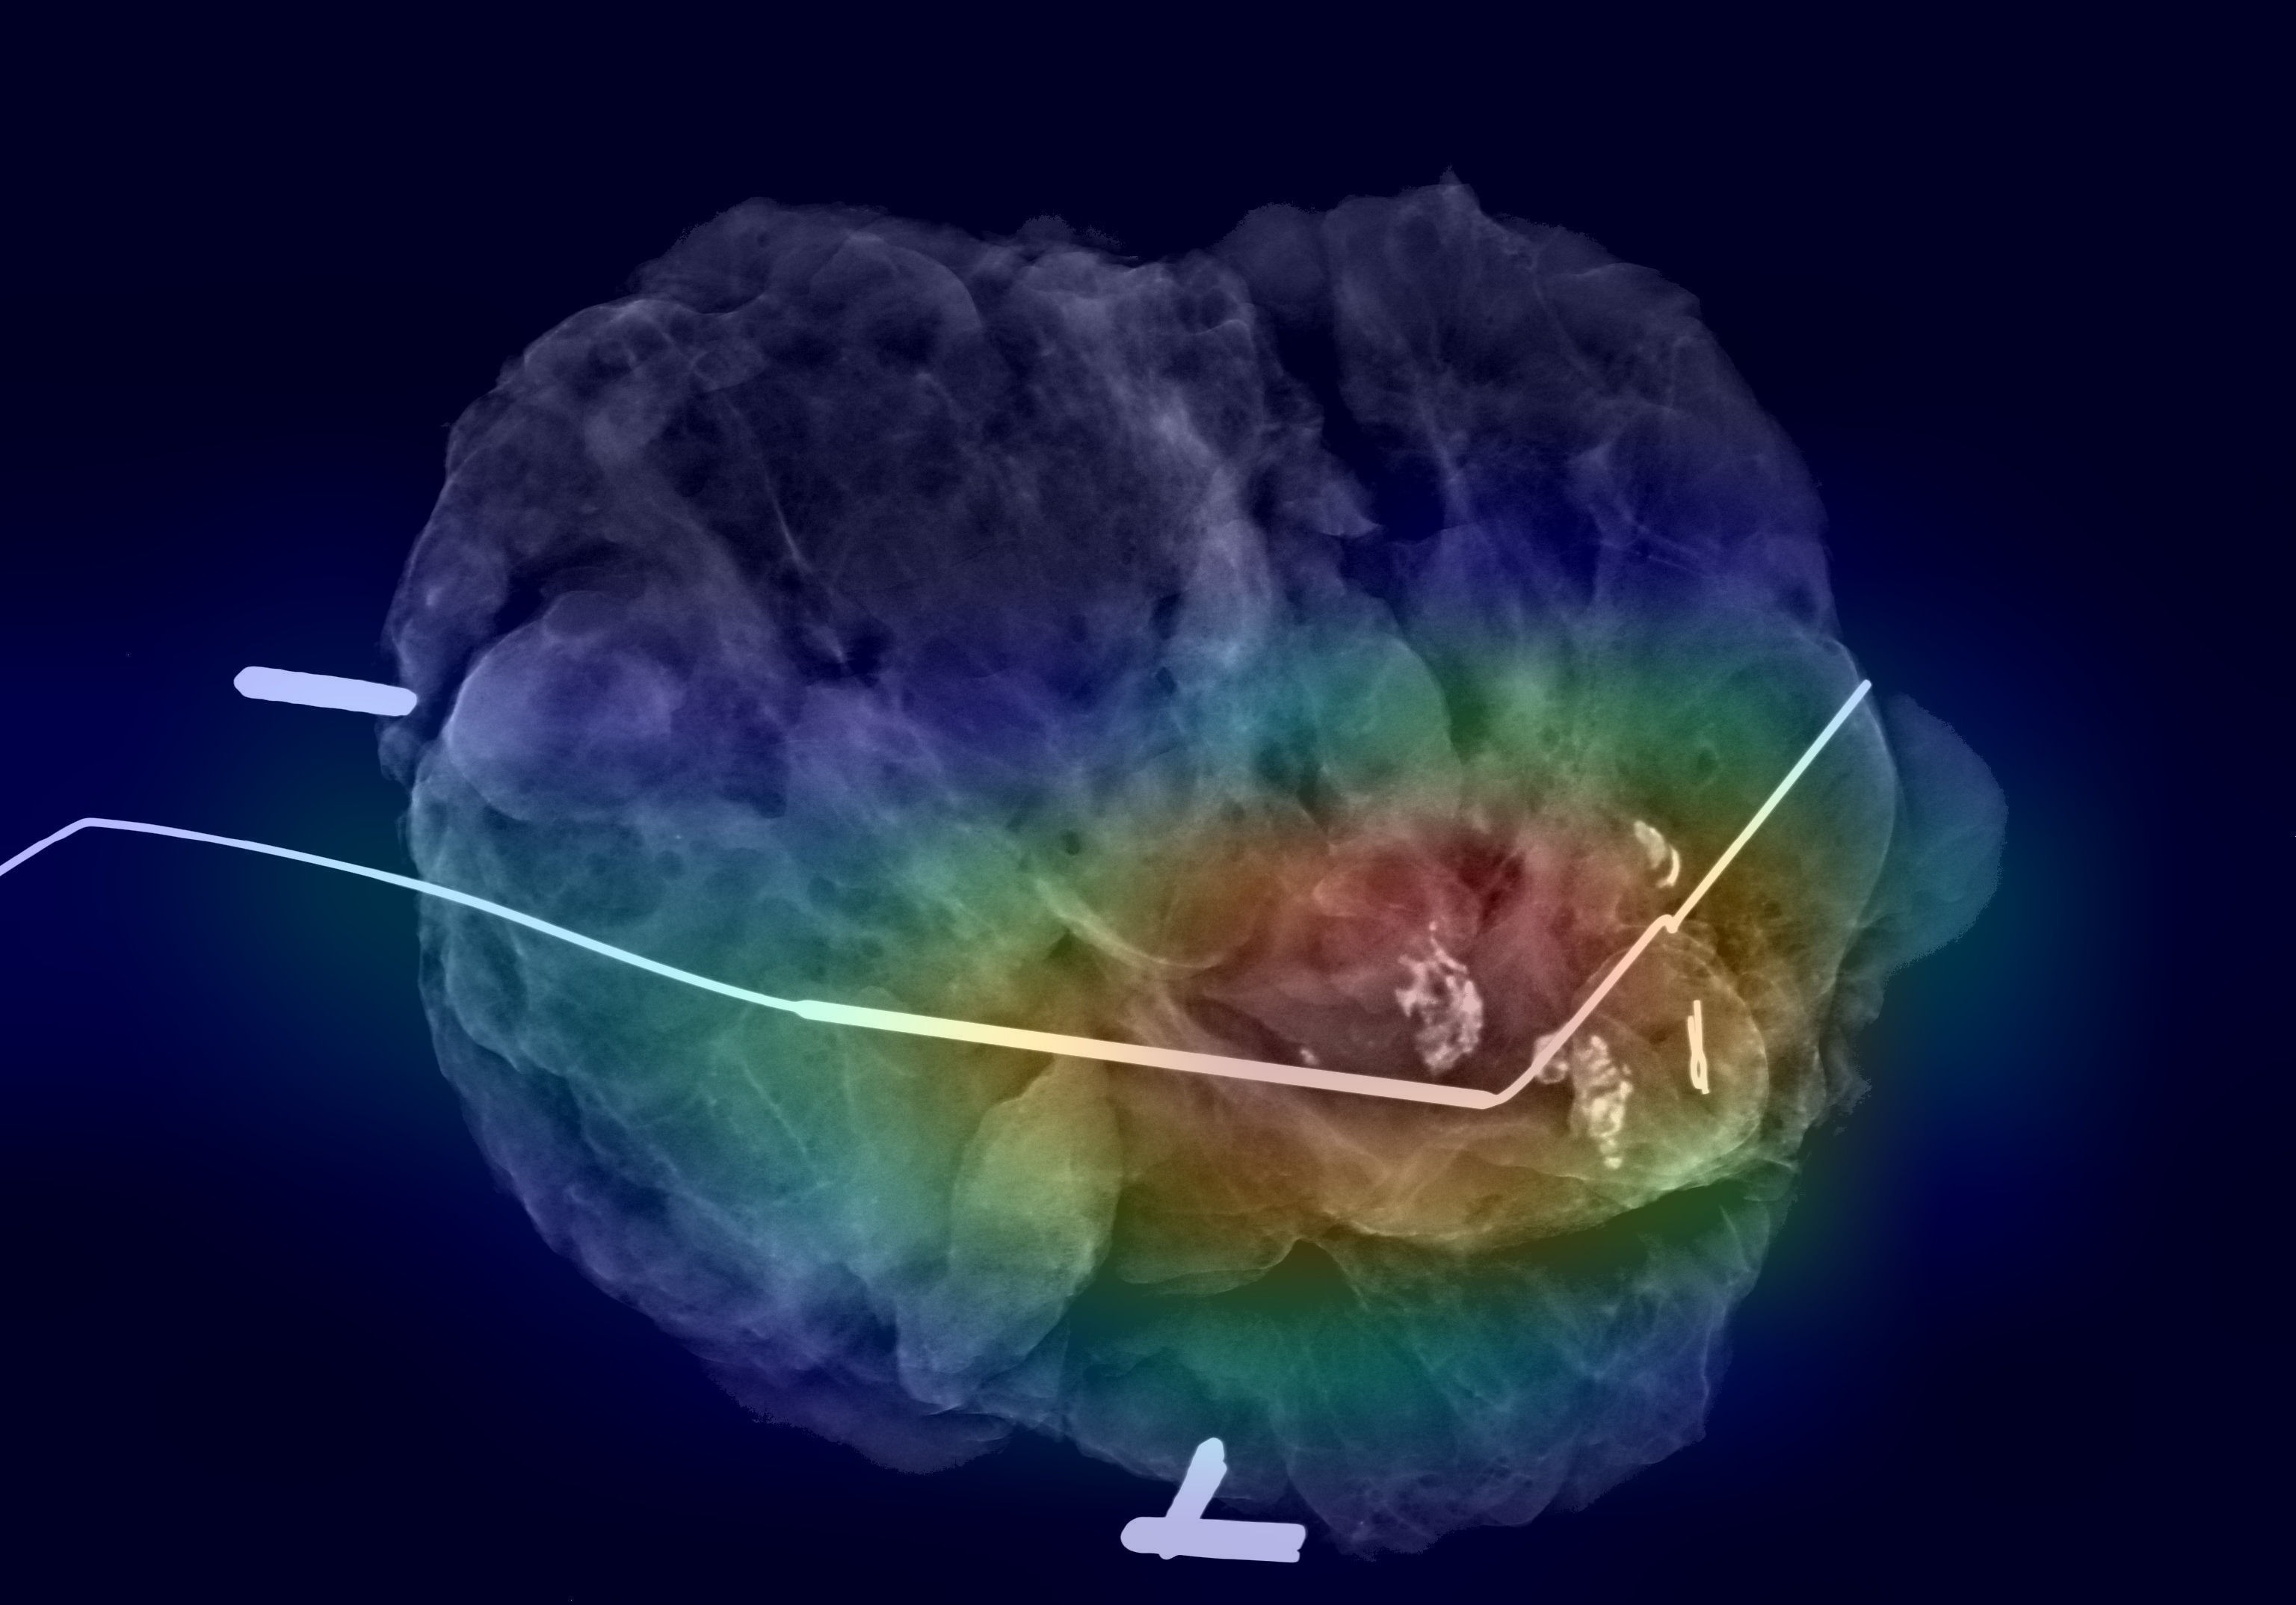

In [ ]:

def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    display(superimposed_img)


save_and_display_gradcam(img_path, heatmap)